# SYDE 552 Project

insert project description here

### IZH 2007

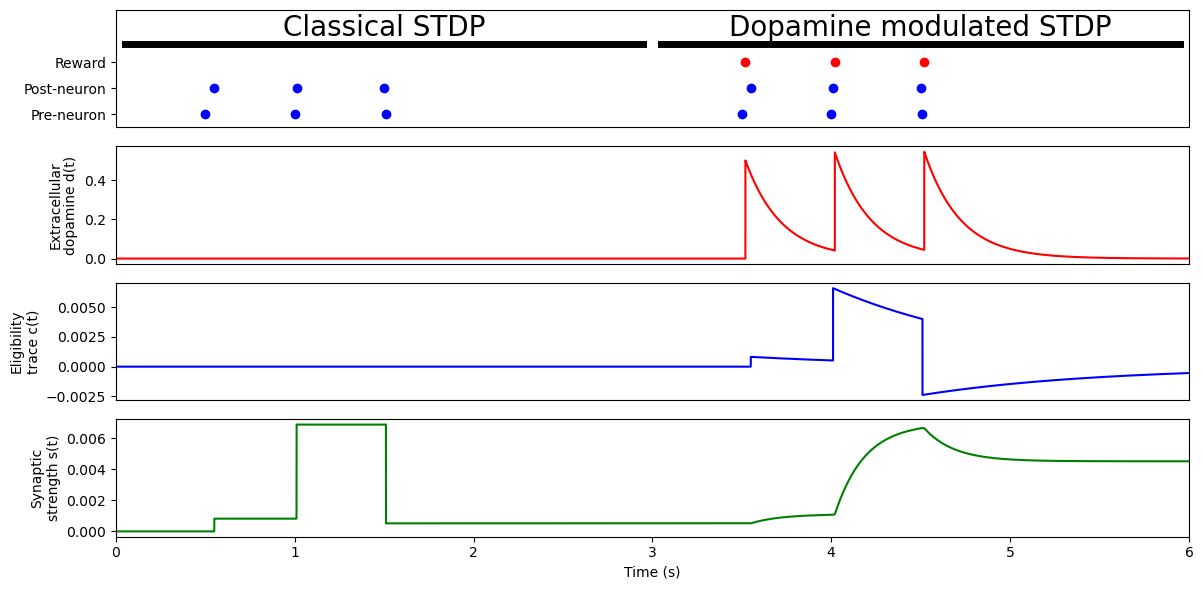

In [1]:
import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

# Below copied from Brian2 
# Parameters
simulation_duration = 6 * second

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

## Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

# Setting the stage

## Stimuli section
input_indices = array([0, 1, 0, 1, 1, 0,
                       0, 1, 0, 1, 1, 0])
input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
spike_input = SpikeGeneratorGroup(2, input_indices, input_times)

neurons = NeuronGroup(2, '''dv/dt = (ge * (Ee-v) + El - v) / taum : volt
                            dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='euler')
neurons.v = vr
neurons_monitor = SpikeMonitor(neurons)

synapse = Synapses(spike_input, neurons,
                   model='''s: volt''',
                   on_pre='v += s')
synapse.connect(i=[0, 1], j=[0, 1])
synapse.s = 100. * mV

## STDP section
synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )
synapse_stdp.connect(i=0, j=1)
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0
synapse_stdp_monitor = StateMonitor(synapse_stdp, ['s', 'c', 'd'], record=[0])

## Dopamine signaling section
dopamine_indices = array([0, 0, 0])
dopamine_times = array([3520, 4020, 4520])*ms
dopamine = SpikeGeneratorGroup(1, dopamine_indices, dopamine_times)
dopamine_monitor = SpikeMonitor(dopamine)
reward = Synapses(dopamine, synapse_stdp, model='''''',
                            on_pre='''d_post += epsilon_dopa''',
                            method='exact')
reward.connect()

# Simulation
## Classical STDP
synapse_stdp.mode = 0
run(simulation_duration/2)
## Dopamine modulated STDP
synapse_stdp.mode = 1
run(simulation_duration/2)

# Visualisation
dopamine_indices, dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12, 6))
subplot(411)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')
text(4.5, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(412)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')
xticks([])
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()

### IZH 2003

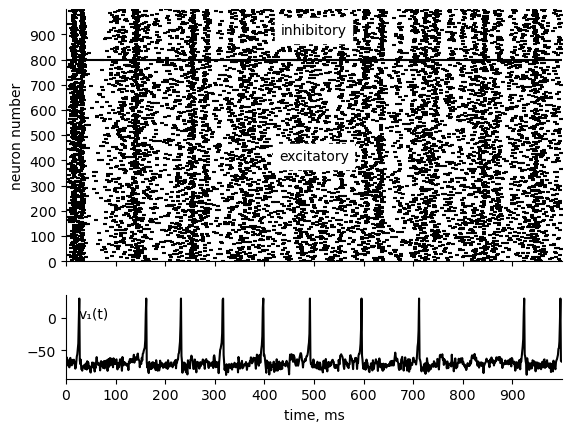

In [3]:
start_scope()

tfinal = 1000 * ms
Ne = 800
Ni = 200

re = np.random.uniform(size=Ne)
ri = np.random.uniform(size=Ni)
weights = np.hstack(
    [
        0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
        -np.random.uniform(size=(Ne + Ni, Ni)),
    ]
).T

defaultclock.dt = 1 * ms

eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

N_exc = N[:Ne]
N_inh = N[Ne:]

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N_exc.a = 0.02
N_exc.b = 0.2
N_exc.c = -65 + 15 * re**2
N_exc.d = 8 - 6 * re**2

N_inh.a = 0.02 + 0.08 * ri
N_inh.b = 0.25 - 0.05 * ri
N_inh.c = -65
N_inh.d = 2

N_exc.u = "b*v"
N_inh.u = "b*v"

S = Synapses(
    N,
    N,
    "w : 1",
    on_pre={"up": "I += w", "down": "I -= w"},
    delay={"up": 0 * ms, "down": 1 * ms},
)
S.connect()
S.w[:] = weights.flatten()

N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

run(tfinal)

fig, (ax, ax_voltage) = plt.subplots(2, 1, sharex=True,
                                     gridspec_kw={'height_ratios': (3, 1)})

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)
ax.set_xlim(0, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='k', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='k', ha='center')

ax_voltage.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30),
               color='k')
ax_voltage.text(25, 0, 'v₁(t)')
ax_voltage.set_xticks(np.arange(0, tfinal / ms, 100))
ax_voltage.spines['right'].set_visible(False)
ax_voltage.spines['top'].set_visible(False)
ax_voltage.set_xlabel("time, ms")

plt.show()